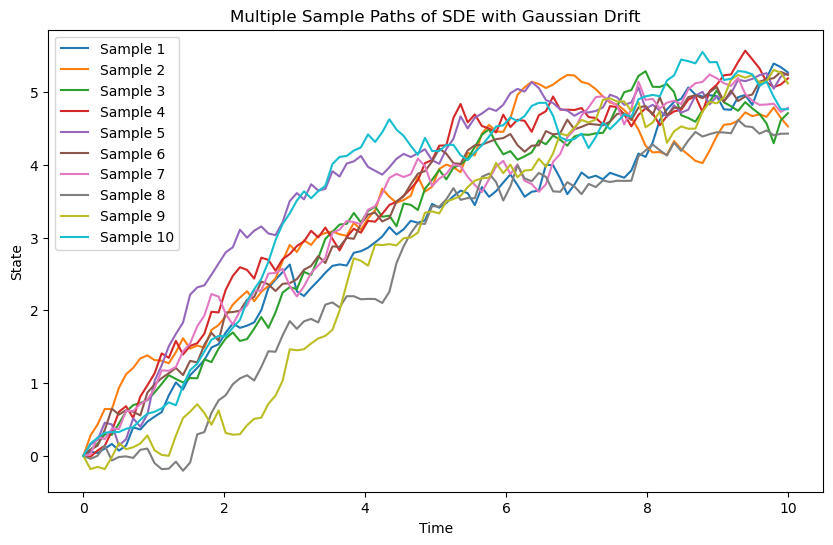

In [1]:
import torch
import torchsde
import matplotlib.pyplot as plt

class GaussianDriftSDE(torchsde.SDEIto):
    def __init__(self, sigma=0.1):
        super(GaussianDriftSDE, self).__init__(noise_type="diagonal")
        self.sigma = sigma  # Diffusion coefficient

    def f(self, t, y):
        """ Drift function of the SDE: -2(t-5)/5 * eaxp(-((t-5)/5)**2) """
        return -2 * (y - 5) / 5 * torch.exp(-((y - 5) / 5)**2)

    def g(self, t, y):
        """ Diffusion function of the SDE: Constant sigma """
        return torch.full_like(y, fill_value=self.sigma)

# Example usage
num_samples = 10  # Define the number of sample paths
y0 = torch.full((num_samples, 1), 0., requires_grad=True)  # Initial states for all samples

ts = torch.linspace(0, 10, 100)  # Time from 0 to 10
sde = GaussianDriftSDE(sigma = 0.4)
# Sample paths using Euler-Maruyama method
ys = torchsde.sdeint(sde, y0, ts, method='euler')  # Using 'euler' for simplicity

# Plotting
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.plot(ts.numpy(), ys[:, i].detach().numpy(), label=f'Sample {i+1}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Multiple Sample Paths of SDE with Gaussian Drift')
plt.legend()
plt.show()

In [94]:
import torch

def derivative_exp_function(t):
    """
    Compute the derivative of the function 5 * exp(-((t - 5) / 5) ** 2) with respect to t.
    
    Args:
    t (torch.Tensor): The input tensor for which the derivative is computed.
    
    Returns:
    torch.Tensor: The derivative of the function at each point in t.
    """
    # Calculate the factor that multiplies the exponential part
    factor = -2 * (t - 5) / 5

    # Calculate the exponential part
    exponential = torch.exp(-((t - 5) / 5) ** 2)

    # Return the product of the factor and the exponential part, scaled by 5
    return 5 * factor * exponential

# Example usage:
t = torch.linspace(0, 10, 100, requires_grad=False)  # Create a tensor of t values
derivative_values = derivative_exp_function(t)

#print(derivative_values)

tensor([ 3.6788,  3.7516,  3.8210,  3.8869,  3.9488,  4.0065,  4.0597,  4.1080,
         4.1513,  4.1891,  4.2213,  4.2475,  4.2675,  4.2811,  4.2880,  4.2879,
         4.2808,  4.2664,  4.2446,  4.2151,  4.1780,  4.1331,  4.0802,  4.0195,
         3.9508,  3.8741,  3.7895,  3.6970,  3.5967,  3.4887,  3.3731,  3.2502,
         3.1200,  2.9828,  2.8389,  2.6884,  2.5318,  2.3692,  2.2012,  2.0279,
         1.8498,  1.6673,  1.4808,  1.2907,  1.0975,  0.9016,  0.7035,  0.5038,
         0.3028,  0.1010, -0.1010, -0.3028, -0.5038, -0.7035, -0.9016, -1.0975,
        -1.2907, -1.4808, -1.6673, -1.8498, -2.0279, -2.2012, -2.3692, -2.5318,
        -2.6884, -2.8389, -2.9828, -3.1200, -3.2502, -3.3731, -3.4887, -3.5967,
        -3.6970, -3.7895, -3.8741, -3.9508, -4.0195, -4.0802, -4.1331, -4.1780,
        -4.2151, -4.2446, -4.2664, -4.2808, -4.2879, -4.2880, -4.2811, -4.2675,
        -4.2475, -4.2213, -4.1891, -4.1513, -4.1080, -4.0597, -4.0065, -3.9488,
        -3.8869, -3.8210, -3.7516, -3.67

In [ ]:
def derivative_exp_function(t):
   
    return 5 * factor * exponential

# Example usage:
t = torch.linspace(0, 10, 100, requires_grad=False)  # Create a tensor of t values
derivative_values = derivative_exp_function(t)

#print(derivative_values)

In [485]:
import torch
import torchsde
import numpy as np
import matplotlib.pyplot as plt
params = {
    "f_hr_max": 180/60,
    "f_hr_min": 40/60,
    "r_tpr_max": 2.134,
    "r_tpr_min": 0.5335,
    "ca": 4.0,
    "cv": 111.0,
    "k_width": 0.1838,
    "p_aset": 70,
    "tau": 20,
    "t_treatment": 15,
    "treatment": True,
    "r_tpr_mod": 0.5,
    "sv_mod": 0.001
}

class PhysiologicalSDE(torchsde.SDEIto):
    def __init__(self, sigma, sigma_tx, params, confounder_type):
        super(PhysiologicalSDE, self).__init__(noise_type="diagonal")
        self.params = params
        self.sigma = sigma
        self.sigma_tx = sigma_tx
        self.confounder_type = confounder_type



    def calculate_diext_dt(self,t, batch_size):
        # Assuming 't' might be a tensor with the shape [batch_size] or a scalar
        # Ensure 't' is at least 1D tensor with the shape [batch_size]
        t = t * torch.ones(batch_size)  # This line is only necessary if t might be a scalar

        # Calculate factor
        factor = -2 * (t - 5) / 5
        # Calculate exponential
        exponential = torch.exp(-((t - 5) / 5) ** 2)

        # Calculate diext_dt and ensure it's of shape [batch x 1]
        diext_dt = 5 * factor * exponential

        return diext_dt.unsqueeze(1)
    
    def create_treatment_effect(self):
        if self.confounder_type == 'visible':
            initp_transform  = 0.5+(self.params["init_pressure"]-0.75)/0.1
            A_ = self.v_fun(initp_transform)
        elif self.confounder_type == 'partial':
            init_sv_transform  = 0.5+(self.params["init_sv"]-0.75)/0.1
            A_ = self.v_fun(init_sv_transform)
        elif self.confounder_type == 'invisible':
            A_ = self.v_fun(self.params["init_random_number"])
        self.treatment_effect = A_
        return A_

    def v_fun(self,x):
        return 0.02*(np.cos(5*x-0.2) * (5-x)**2)**2

    def f(self, t, y):
        p_a = 100. * y[:, 0].unsqueeze(1)
        p_v = 10. * y[:, 1].unsqueeze(1)
        s = y[:, 2].unsqueeze(1)
        sv = 100. * y[:, 3].unsqueeze(1)
        i_ext = y[:, 4].unsqueeze(1)
        batch_size = y.shape[0]
        
        #defining our treatment effect A_ (which we cannot explain with our model), and has a functional dep on the original blood pressure and a form of v_fun
        A_ = self.create_treatment_effect()
        i_ext_tx_effect = A_ * i_ext

        f_hr = s * (self.params["f_hr_max"] - self.params["f_hr_min"]) + self.params["f_hr_min"]
        r_tpr = s * (self.params["r_tpr_max"] - self.params["r_tpr_min"]) + self.params["r_tpr_min"] - self.params["r_tpr_mod"]

        dva_dt = -1. * (p_a - p_v) / r_tpr + sv * f_hr
        dvv_dt = -1. * dva_dt + i_ext_tx_effect
        dpa_dt = dva_dt / (self.params["ca"] * 100.)
        dpv_dt = dvv_dt / (self.params["cv"] * 10.)
        ds_dt = (1. / self.params["tau"]) * (1. - 1. / (1 + torch.exp(-self.params["k_width"] * (p_a - self.params["p_aset"]))) - s)
        dsv_dt = i_ext_tx_effect * self.params["sv_mod"]

        if self.params["treatment"] and (t >= self.params["t_treatment"]):
            #note that the 
            time_since_treatment = t - self.params["t_treatment"]
            diext_dt = self.calculate_diext_dt(time_since_treatment, batch_size)
            diext_dt = torch.relu(i_ext + diext_dt) - i_ext 
        else:
            #diext_dt = torch.full((batch_size, 1), 1)
            diext_dt = torch.zeros_like(dpa_dt)

        ##print('dpa_dt, dpv_dt, ds_dt, dsv_dt, diext_dt',dpa_dt.shape, dpv_dt.shape, ds_dt.shape, dsv_dt.shape, diext_dt.shape )

        
        diff_res = torch.concat([dpa_dt, dpv_dt, ds_dt, dsv_dt, diext_dt], dim=-1)

        ##print('diff_res', diff_res.shape)
        return diff_res
    
    def g(self, t, y):
        diffusion = torch.full_like(y, self.sigma)
        if self.params["treatment"] and (t >= self.params["t_treatment"]):
            diffusion[:, 4] = self.sigma_tx
        return diffusion



In [486]:
params['init_pressure'] = 0.7
params['init_sv'] = 0.9

sde = PhysiologicalSDE(sigma = 0.0, sigma_tx=3, confounder_type='partial' , params=params)

# Setup initial conditions and time
num_samples = 1
y0 = torch.tensor([[params['init_pressure'] , 0.5, 0.2, params['init_sv'], 0]] * num_samples, dtype=torch.float32)  # Repeat initial conditions for all samples
ts = torch.linspace(0, 30, 100)  # Time vector

# Simulate
ys = torchsde.sdeint(sde, y0, ts, method='euler')


In [489]:
ys.squeeze(1).shape

torch.Size([100, 5])

In [275]:
y0 = torch.tensor([[params['init_pressure'] , 0.5, 0.2, params['init_sv'], 0]] * num_samples, dtype=torch.float32)  # Repeat initial conditions for all samples
y0.shape

torch.Size([1, 5])

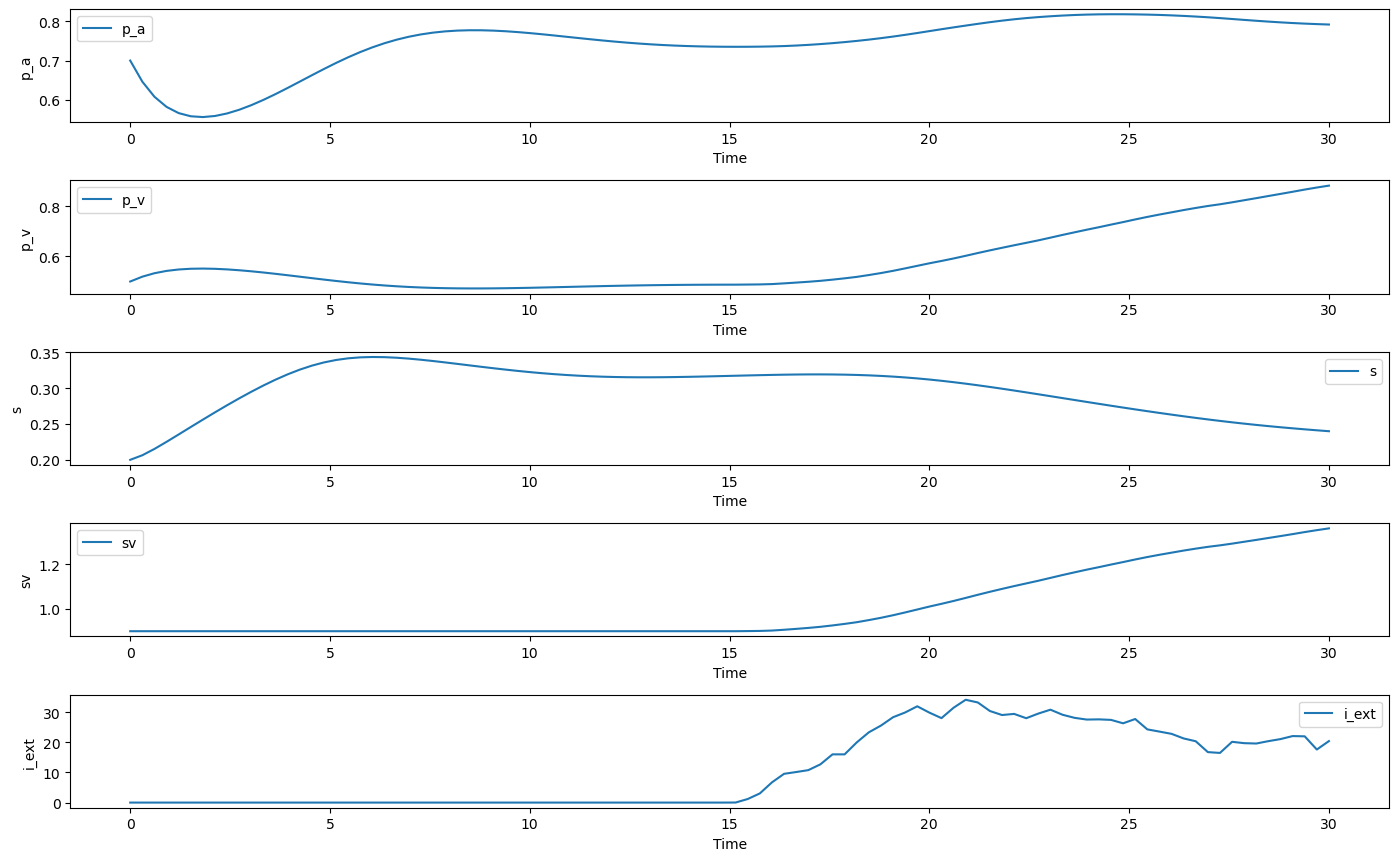

In [262]:
def plot_sde_results_with_i_ext(ts, ys):
    plt.figure(figsize=(14, 10))
    num_variables = ys.shape[2]
    labels = ['p_a', 'p_v', 's', 'sv', 'i_ext']

    for i in range(num_variables):
        plt.subplot(num_variables + 1, 1, i + 1)
        plt.plot(ts, ys[:, 0, i], label=f'{labels[i]}')
        plt.xlabel('Time')
        plt.ylabel(labels[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_sde_results_with_i_ext(ts, ys)

In [77]:
def calculate_diext_dt(t, batch_size):
        # Assuming 't' might be a tensor with the shape [batch_size] or a scalar
        # Ensure 't' is at least 1D tensor with the shape [batch_size]
        t = t * torch.ones(batch_size)  # This line is only necessary if t might be a scalar

        # Calculate factor
        factor = -2 * (t - 5) / 5
        # Calculate exponential
        exponential = torch.exp(-((t - 5) / 5) ** 2)

        # Calculate diext_dt and ensure it's of shape [batch x 1]
        diext_dt = 5 * factor * exponential
        diext_dt = diext_dt.unsqueeze(1)  # Ensure the shape is [batch x 1]

        return diext_dt



tensor([[1.8397e+00],
        [1.8404e+00],
        [1.8412e+00],
        ...,
        [6.1917e-04],
        [6.1843e-04],
        [6.1768e-04]])

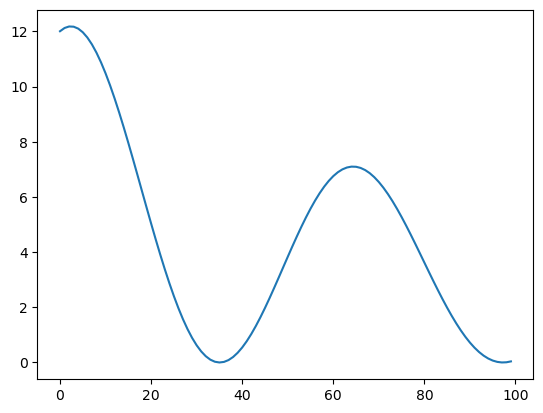

In [42]:
def v_fun(x):
    return 0.02*(np.cos(5*x-0.2) * (5-x)**2)**2


x = np.linspace(0, 1, 100)
initp_transform  = 0.5+(x-0.75)/0.1

plt.plot(v_fun(x))

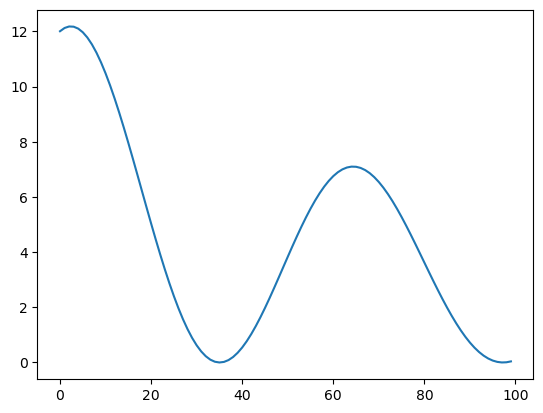

In [44]:

x = np.linspace(0.7, 0.8, 100)
initp_transform  = 0.5+(x-0.75)/0.1

plt.plot(v_fun(initp_transform))

In [24]:
import torch
import os

import torchsde
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import lightning as L

from utils_6 import CV_params_prior_mu, CV_params_prior_sigma, CV_params

class PhysiologicalSDE_batched(torchsde.SDEIto):
    def __init__(self, sigma, sigma_tx, params, confounder_type,non_confounded_effect):
        super(PhysiologicalSDE_batched, self).__init__(noise_type="diagonal")
        self.params = params
        self.sigma = sigma
        self.sigma_tx = sigma_tx
        self.confounder_type = confounder_type
        self.non_confounded_effect = non_confounded_effect

    def calculate_diext_dt(self,t, batch_size):
        # Assuming 't' might be a tensor with the shape [batch_size] or a scalar
        # Ensure 't' is at least 1D tensor with the shape [batch_size]
        t = t * torch.ones(batch_size)  # This line is only necessary if t might be a scalar

        # Calculate factor
        factor = -2 * (t - 5) / 5
        # Calculate exponential
        exponential = torch.exp(-((t - 5) / 5) ** 2)

        # Calculate diext_dt and ensure it's of shape [batch x 1]
        diext_dt = 5 * factor * exponential

        return diext_dt.unsqueeze(1)
    
    def create_treatment_effect(self):
        if self.confounder_type == 'visible':
            #confound on the initial NORMALISED PA - STATIC CONFOUNDER (not time dep)
            initp_transform  = 0.5+(self.params["confounding_pressure"]-0.75)/0.1
            ##print('initp_transform', initp_transform.shape)
            A_ = self.v_fun(initp_transform)
        elif self.confounder_type == 'partial':
            #confound on the initial NORMALISED SV - STATIC CONFOUNDER (not time dep)
            init_sv_transform  = 0.5+(self.params["confounding_sv"]-0.2)/0.1 
            A_ = self.v_fun(init_sv_transform)
        elif self.confounder_type == 'invisible':
            A_ = self.v_fun(self.params["confounder_random_number"])
        self.treatment_effect = A_
        return A_

    def v_fun(self, x):
        cos_term = torch.cos(5 * x - 0.2)
        square_term = (5 - x) ** 2
        return 0.02 * (cos_term * square_term) ** 2

    def f(self, t, y):
        ##print('y', y.shape)
        p_a = 100. * y[:, 0].unsqueeze(1)
        p_v = 100. * y[:, 1].unsqueeze(1)
        s = y[:, 2].unsqueeze(1)
        sv = 100. * y[:, 3].unsqueeze(1)
        i_ext = y[:, 4].unsqueeze(1)
        batch_size = y.shape[0]

        ##print('pa', p_a.shape)
        #print(t.item())


        if t.item() == 0:
            ##print(t)
            #print('saving params')
            self.params["confounding_pressure"] = y[:, 0]
            self.params["confounding_sv"] = y[:, 3]
            self.params["cv"] = torch.rand_like(y[:, 0]) * 100 + 10 if self.non_confounded_effect else self.params["cv"] 
            self.params["confounder_random_number"] = torch.rand_like(y[:, 0])
            ##print('self.params["init_pressure"]', self.params["init_pressure"].shape)
            ##print('self.params["init_sv"]', self.params["init_sv"].shape)
        
            #defining our treatment effect A_ (which we cannot explain with our model), and has a functional dep on the original blood pressure and a form of v_fun
        
        A_ = self.create_treatment_effect()
        #print('A_, i_ext', A_, i_ext)
        i_ext_tx_effect = A_.unsqueeze(1) * i_ext
        ##print('i_ext_tx_effect', i_ext_tx_effect.shape)

        #print('time, i_ext, p_a pv, s, sv', t.item(), i_ext_tx_effect[0].item(), p_a[0].item(), p_v[0].item(), s[0].item(), sv[0].item())   

        #print('t, i_ext_effect', t,i_ext_tx_effect )

        f_hr = s * (self.params["f_hr_max"] - self.params["f_hr_min"]) + self.params["f_hr_min"]
        r_tpr = s * (self.params["r_tpr_max"] - self.params["r_tpr_min"]) + self.params["r_tpr_min"] - self.params["r_tpr_mod"]

        dva_dt = -1. * (p_a - p_v) / r_tpr + sv * f_hr
        dvv_dt = -1. * dva_dt + i_ext_tx_effect
        dpa_dt = dva_dt / (self.params["ca"] * 100.)
        dpv_dt = dvv_dt / (self.params["cv"] * 10.)
        ds_dt = (1. / self.params["tau"]) * (1. - 1. / (1 + torch.exp(-self.params["k_width"] * (p_a - self.params["p_aset"]))) - s)
        dsv_dt = i_ext_tx_effect * self.params["sv_mod"]

        if self.params["treatment"] and (t >= self.params["t_treatment"]):
            #note that the 
            time_since_treatment = t - self.params["t_treatment"]
            diext_dt = self.calculate_diext_dt(time_since_treatment, batch_size)
            diext_dt = torch.relu(i_ext + diext_dt) - i_ext 
        else:
            #diext_dt = torch.full((batch_size, 1), 1)
            diext_dt = torch.zeros_like(dpa_dt)

        ##print('dpa_dt, dpv_dt, ds_dt, dsv_dt, diext_dt',dpa_dt.shape, dpv_dt.shape, ds_dt.shape, dsv_dt.shape, diext_dt.shape )

        
        diff_res = torch.concat([dpa_dt, dpv_dt, ds_dt, dsv_dt, diext_dt], dim=-1)

        ##print('diff_res', diff_res.shape)
        return diff_res
    
    def g(self, t, y):
        diffusion = torch.full_like(y, self.sigma)
        if self.params["treatment"] and (t >= self.params["t_treatment"]):
            diffusion[:, 4] = self.sigma_tx
        return diffusion





def scale_numbers(x, original_min, original_max, target_min, target_max):
    return target_min + ((target_max - target_min) * (x - original_min) / (original_max - original_min))


def init_random_state():
    max_ves = 64.0 - 10.0
    min_ves = 36.0 + 10.0

    max_ved = 167.0 - 10.0
    min_ved = 121.0 + 10.0

    max_pa = 85.0
    min_pa = 75.0

    max_pv = 70.0
    min_pv = 30.0

    max_s = 0.25
    min_s = 0.15

    max_sv = 100
    min_sv = 90

    init_ves = (np.random.rand() * (max_ves - min_ves) + min_ves) / 100.0
    # init_ves = 50.0 / 100.0

    init_ved = (np.random.rand() * (max_ved - min_ved) + min_ved) / 100.0
    # init_ved = 144.0 / 100.0

    init_pa = (np.random.rand() * (max_pa - min_pa) + min_pa) / 100.0
    init_pv = (np.random.rand() * (max_pv - min_pv) + min_pv) / 100.0
    init_s = (np.random.rand() * (max_s - min_s) + min_s)
    init_sv = (np.random.rand() * (max_sv - min_sv) + min_sv) / 100.0

    init_i_ext = 0

    init_state = np.array([init_pa, init_pv, init_s, init_sv, init_i_ext])
    ##print('init_state', init_state)
    return init_state



def create_cv_data(N,gamma,noise_std, sigma_tx, confounder_type, non_confounded_effect, t_span, t_treatment, seed, post_treatment_dims, pre_treatment_dims, normalize = False):

    np.random.seed(seed)

    X = []
    Y_0 = []
    Y_1 = []
    init_state_list = []
    
    params = {"r_tpr_mod": 0.0, #the mod is in case we want to simulate decreasing the total peripheral resistance i.e. shock
            "f_hr_max": 3.0,
            "f_hr_min": 2.0 / 3.0,
            "r_tpr_max": 2.134,
            "r_tpr_min": 0.5335,
            "sv_mod": 0.001,  ## this is also added on from the original model to simulate effect of fluid directly on the stroke volume
            "ca": 4.0,
            "cv": 111.0,

            # dS/dt parameters
            "k_width": 0.1838,
            "p_aset": 70,
            "tau": 20,
            "p_0lv": 2.03,
            "r_valve": 0.0025,
            "k_elv": 0.066,
            "v_ed0": 7.14,
            "T_sys": 4. / 15.,
            "cprsw_max": 103.8,
            "cprsw_min": 25.9,
            "t_treatment" : t_treatment,
            }
    
    params_treatment = params.copy()
    params_treatment["treatment"]=True
    params_notreatment = params.copy()
    params_notreatment["treatment"]=False
    

    t = np.arange(t_span).astype(float)
    t_tensor = torch.tensor(t, dtype=torch.float32)

    #print(f"N: {N}")
    #print(f"Gamma: {gamma}")
    #print(f"Noise Std: {noise_std}")
    #print(f"Sigma Tx: {sigma_tx}")
    #print(f"Confounder Type: {confounder_type}")
    #print(f"Non Confounded Effect: {non_confounded_effect}")
    #print(f"t_span: {t_span}")
    #print(f"t_treatment: {t_treatment}")
    #print(f"Seed: {seed}")
    #print(f"Post Treatment Dims: {post_treatment_dims}")
    #print(f"Pre Treatment Dims: {pre_treatment_dims}")
    #print(f"Normalize: {normalize}")

    #print('creating initial random states for both treated and untreated ')
    init_state_list = []
    for i in range(N):
        init_state_list.append(init_random_state())
    init_state_tensor = torch.tensor(np.array(init_state_list), dtype=torch.float32)

    #creating treated from those initial random states
    #print('creating treated')
    print('init_state_tensor', init_state_tensor.shape, 't_tensor', t_tensor.shape, )
    sde = PhysiologicalSDE_batched(sigma = noise_std, sigma_tx=sigma_tx, confounder_type=confounder_type , non_confounded_effect = non_confounded_effect, params=params_treatment)
    Y_1 = torchsde.sdeint(sde, init_state_tensor, t_tensor, method='euler').squeeze(1)

    #print('creating untreated')
    #created untreated from the same initial random satates
    sde = PhysiologicalSDE_batched(sigma = noise_std, sigma_tx=sigma_tx, confounder_type=confounder_type , non_confounded_effect = non_confounded_effect, params=params_notreatment)
    Y_0 = torchsde.sdeint(sde, init_state_tensor, t_tensor, method='euler').squeeze(1)
        
    X = init_state_tensor
    init_state = init_state_tensor
        
    #print('Assigning confounding factors')
    ##print('init_state', init_state.shape)
    if confounder_type == 'visible':
        scaled_pa = scale_numbers(x=init_state[:, 0], original_min=0.75, original_max=0.85, target_min=0, target_max=1)
        p = torch.sigmoid(gamma*scaled_pa) # use the arterial pressure as visible confounder
    
    elif confounder_type == 'partial':# use the stroke volume as a partially visible confounder
        scaled_sv = scale_numbers(x=init_state[:, 3], original_min=0.9, original_max=1, target_min=0, target_max=1)
        p  = torch.sigmoid(gamma*scaled_sv) 

    elif confounder_type == 'invisible':
        p =  torch.sigmoid(gamma*torch.rand(N)) 

    ##print('p', p.shape)
    T = torch.zeros(N)
    #T determines which trajectories as selected as treated (overlap level is controlled by gamma)
    T[torch.rand(N)<p] = 1

    #all_trajectories = torch.cat([Y_0, Y_1], dim = 1)
    Y_0 = Y_0[:, :, :4].permute(1, 0, 2)  # drop the dim used to create I-external and permute to [batch, seq_len, dim]
    Y_1 = Y_1[:, :, :4].permute(1, 0, 2)
    T_expanded = T[:, None, None]
    #print('Y0, Y1, T_expanded', Y_0.shape, Y_1.shape, T_expanded.shape)

    # the 'factual' trajectories are the UNtreated outcome (Y0) for the not Treated (1-T) and the Treated outcome (Y1) for the factually Treated (T)
    Y_fact = Y_0 * (1-T_expanded)+ Y_1 *T_expanded

    # the 'COUNTERfactual' trajectories are the UNtreated outcome (Y0) for the Treated (T) and the Treated outcome (Y1) for the factually UNtreated (1-T)
    # we would never actually have access to the counterfactual other than in this situation where we are simulating it 
    Y_cf = Y_0 * T_expanded + Y_1 * (1-T_expanded)

    
    Y_fact_np = Y_fact.detach().cpu().numpy()
    states_mean = Y_fact_np.mean(axis=(0, 1))
    states_min = Y_fact_np.min(axis=(0, 1))
    states_max = Y_fact_np.max(axis=(0, 1))
    #print('states_mean', states_mean, 'states_min', states_min, 'states_max', states_max)

    
    Y_fact_until_t = Y_fact[:, :t_treatment, :]
    mu = Y_fact_until_t.mean([0,1])
    std = Y_fact_until_t.std([0,1])
    
    if normalize:
        Y_fact = (Y_fact - mu)/std
        Y_cf = (Y_cf - mu)/std
        mu_X = X.mean([0,1])
        std_X = X.std([0,1])
        X = (X-mu_X)/std_X

    CV_params_prior_mu['pa'] = mu[0]*100
    CV_params_prior_mu['pv'] = mu[1] *100
    CV_params_prior_mu['s'] = mu[2]
    CV_params_prior_mu['sv'] = mu[3] *100

    CV_params_prior_sigma['pa'] = std[0]*100
    CV_params_prior_sigma['pv'] = std[1]*100
    CV_params_prior_sigma['s'] = std[2]
    CV_params_prior_sigma['sv'] = std[3]*100

    CV_params['max_pa'] = (mu[0] + 2.5 * std[0]) * 100
    CV_params['min_pa'] = (mu[0] - 2.5 * std[0]) * 100
    CV_params['max_pv'] = (mu[1] + 2.5 * std[1]) * 100
    CV_params['min_pv'] = (mu[1] - 2.5 * std[1]) * 100
    CV_params['max_s'] = (mu[2] + 2.5 * std[2]) 
    CV_params['min_s'] = (mu[2] - 2.5 * std[2]) 
    CV_params['max_sv'] = (mu[3] + 2.5 * std[3]) * 100
    CV_params['min_sv'] = (mu[3] - 2.5 * std[3]) * 100

    
    # Now split these factual and counterfactual trajectories by the 'before' and 'after treatment' so we have a baseline 
    pre_treat_mask = (t<=t_treatment)
    post_treat_mask = (t>t_treatment)
    
    # We define X as the Factual trajectory BEFORE treatment, and X_ as the COUNTERfactual traj BEFORE treatment 
    X_static = X
    X = Y_fact[:,pre_treat_mask][:,:,pre_treatment_dims]
    X_ = Y_cf[:,pre_treat_mask][:,:,pre_treatment_dims]

    # We redfine Y_fact as the Factual trajectory AFTER treatment, and Y_cf as the COUNTERfactual traj AFTER treatment 
    # We are selecting the DIASTOLIC BP (output dim = 1) as the one to maintain.. this is because the fluid is only really affecting this within the time values
    full_fact_traj = Y_fact
    full_CF_traj = Y_cf

    Y_fact = Y_fact[:,post_treat_mask][:,:,post_treatment_dims] 
    Y_cf = Y_cf[:,post_treat_mask][:,:,post_treatment_dims]

    # we split the time vector also as before and after treatment 
    t_x = t[pre_treat_mask]
    t_y = t[post_treat_mask]
    # and get it to match the dimensions, so it's not a vector t, but a matrix of dimensions N by before_tx and N by after_tx
    t_X = torch.Tensor(np.tile(t_x[None,:],(X.shape[0],1)))
    t_Y = torch.Tensor(np.tile(t_y[None,:],(Y_fact.shape[0],1))) - t_x[-1]
    t_FULL = t_tensor.unsqueeze(0).repeat(X.shape[0], 1)
    expert_ODE_size = X.shape[1] - 1 #need to remove the i_ext which is only for creating data not models


    return X, X_static, T, Y_fact, Y_cf, p, init_state, t_X, t_Y, expert_ODE_size, t_FULL, full_fact_traj,full_CF_traj, sde




def create_load_save_data(dataset_params, data_path):
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        print(f"Created directory: {data_path}")

    non_confounded_effect_str = 'true' if dataset_params['non_confounded_effect'] else 'false'
    normalize = 'true' if dataset_params['normalize'] else 'false'
    post_treatment_dims_str = ''.join(map(str, dataset_params['post_treatment_dims']))
    pre_treatment_dims_str = ''.join(map(str, dataset_params['pre_treatment_dims']))

    # Create a descriptive file name
    filename = f"{dataset_params['confounder_type']}_RCE{non_confounded_effect_str}_N{dataset_params['N']}_G{dataset_params['gamma']}_Dstd{dataset_params['noise_std']}_Tstd{dataset_params['sigma_tx']}_Pre{pre_treatment_dims_str}_Post{post_treatment_dims_str}_Norm{normalize}.pt"
    final_data_path = os.path.join(data_path, filename)

    if os.path.exists(final_data_path):
        print("Loading existing dataset.")
        data = torch.load(final_data_path)

    else:
        print("Creating and saving a new dataset.")
        # Generate data
        X, X_static, T, Y_fact, Y_cf, p, init_state, t_X, t_Y, expert_ODE_size, t_FULL, full_fact_traj,full_CF_traj, sde = create_cv_data(N = dataset_params['N'],
                                                                                                                                      gamma = dataset_params['gamma'],
                                                                                                                                      noise_std = dataset_params['noise_std'], 
                                                                                                                                      sigma_tx = dataset_params['sigma_tx'], 
                                                                                                                                      confounder_type = dataset_params['confounder_type'], 
                                                                                                                                      non_confounded_effect = dataset_params['non_confounded_effect'], 
                                                                                                                                      t_span = dataset_params['t_span'], 
                                                                                                                                      t_treatment = dataset_params['t_treatment'], 
                                                                                                                                      seed = dataset_params['seed'], 
                                                                                                                                      post_treatment_dims = dataset_params['post_treatment_dims'], 
                                                                                                                                      pre_treatment_dims = dataset_params['pre_treatment_dims'], 
                                                                                                                                      normalize = dataset_params['normalize'])
    
        data = {'X': X, 'T': T,'Y_fact': Y_fact, 'Y_cf': Y_cf,'p': p,'init_state': init_state,'t_X': t_X,'t_Y': t_Y,'t_full': t_FULL,'full_fact_traj': full_fact_traj,'full_CF_traj': full_CF_traj }
        # Save the dataset
        torch.save(data, final_data_path)
    
    return data




class CVDataset_loaded(Dataset):
    def __init__(self, data):
        # Unpack the data
        self.X = data['X']
        self.T = data['T']
        self.Y_fact = data['Y_fact']
        self.Y_cf = data['Y_cf']
        self.p = data['p']
        self.init_state = data['init_state']
        self.t_X = data['t_X']
        self.t_Y = data['t_Y']
        self.t_full = data['t_full']
        self.full_fact_traj = data['full_fact_traj']
        self.full_CF_traj = data['full_CF_traj']

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y_fact[idx], self.T[idx], self.Y_cf[idx], self.p[idx], self.init_state[idx],self.t_X[idx], self.t_Y[idx], self.t_full[idx], self.full_fact_traj[idx],self.full_CF_traj[idx]




class CVDataModule_final(L.LightningDataModule):
    def __init__(self, dataset_path, batch_size=32, num_workers =1):
        super().__init__()
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dataset = None
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Load the dataset
        data = torch.load(self.dataset_path)
        self.dataset = CVDataset_loaded(data)
        
        train_idx = np.arange(len(self.dataset))[:int(0.5*len(self.dataset))]
        val_idx = np.arange(len(self.dataset))[int(0.5*len(self.dataset)):]
        test_idx = val_idx[int(len(val_idx)/2):]
        val_idx = val_idx[:int(len(val_idx)/2)]

        self.train = Subset(self.dataset,train_idx)
        self.val = Subset(self.dataset,val_idx)
        self.test = Subset(self.dataset,test_idx)

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=True,
            drop_last=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True, 
            drop_last=False,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True
            )




In [34]:
dataset_params = {
        'N': 1000,
        'gamma': 5,
        'noise_std': 0.0,
        'sigma_tx': 4,
        'confounder_type': 'partial',
        'non_confounded_effect': False,
        't_span': 26,
        't_treatment': 15,
        'seed': 1,
        'pre_treatment_dims': [0, 1],
        'post_treatment_dims': [1],
        'normalize': False
    }




#path = "/Users/riccardoconci/Local_documents/ACS submissions/THESIS/Core_paper_implementations/cf-ode/causalode/data_rc/" 
path = '/Users/riccardoconci/Local_documents/ACS submissions/THESIS/Counterfactual_ICU/Experiment_6b/data_created'
data = create_load_save_data(dataset_params,path )
#cv_data_module = CVDataModule_final(data,  batch_size=32, num_workers =1)

Creating and saving a new dataset.
init_state_tensor torch.Size([1000, 5]) t_tensor torch.Size([26])


In [47]:
params = {
    "f_hr_max": 180/60,
    "f_hr_min": 40/60,
    "r_tpr_max": 2.134,
    "r_tpr_min": 0.5335,
    "ca": 4.0,
    "cv": 111.0,
    "k_width": 0.1838,
    "p_aset": 70,
    "tau": 20,
    "t_treatment": 15,
    "treatment": True,
    "r_tpr_mod": 0.0,
    "sv_mod": 0.001
}

N = 1000
gamma = 0
noise_std = 0.0
sigma_tx = 4
confounder_type = 'partial'
non_confounded_effect = False
t_span = 26
t_treatment = 15
seed = 1
pre_treatment_dims = [0,1]
post_treatment_dims = [1]
normalize = False


X, X_static, T, Y_fact, Y_cf, p, init_state, t_X, t_Y, expert_ODE_size, t_FULL, full_fact_traj,full_CF_traj, sde = create_cv_data(N,gamma,noise_std, sigma_tx, confounder_type, non_confounded_effect, t_span, t_treatment, seed, post_treatment_dims, pre_treatment_dims, normalize)


time_slice = full_fact_traj[:, 15, :]
max_values_at_15 = time_slice.max(dim=0)[0]  # Max over samples, for each variable
min_values_at_15 = time_slice.min(dim=0)[0]  
print(min_values_at_15)
print(max_values_at_15)

{'pa': tensor(106.0743),
 'pv': tensor(40.1797),
 's': tensor(0.1465),
 'sv': tensor(95.2293),
 'sv_mod': 0.001,
 'ca': 4.0,
 'cv': 111.0,
 'k_width': 0.1838,
 'p_aset': 70,
 'tau': 20,
 'p_0lv': 2.03,
 'r_valve': 0.0025,
 'k_elv': 0.066,
 'v_ed0': 7.14,
 'T_sys': 0.26666666666666666,
 'hr': 1.83333,
 'tpr': 1.33375,
 'cprsw': 64.85}

In [ ]:
params_treatment = {"r_tpr_mod": 0.0, #the mod is in case we want to simulate decreasing the total peripheral resistance i.e. shock
            "f_hr_max": 3.0,
            "f_hr_min": 2.0 / 3.0,
            "r_tpr_max": 2.134,
            "r_tpr_min": 0.5335,
            "sv_mod": 0.001,  ## this is also added on from the original model to simulate effect of fluid directly on the stroke volume
            "ca": 4.0,
            "cv": 111.0,

            # dS/dt parameters
            "k_width": 0.1838,
            "p_aset": 70,
            "tau": 20,
            "p_0lv": 2.03,
            "r_valve": 0.0025,
            "k_elv": 0.066,
            "v_ed0": 7.14,
            "T_sys": 4. / 15.,
            "cprsw_max": 103.8,
            "cprsw_min": 25.9,
            "t_treatment" : 8,
            }

params_treatment["treatment"]=True
init_state = [[104.7823/100, 40.4436/100, 0.1450, 94.2049/100, 0],[104.7823/100, 40.4436/100, 0.1450, 94.2049/100, 0]]
init_state_tensor = torch.tensor(np.array(init_state), dtype=torch.float32)
t = np.arange(10).astype(float)
t_tensor = torch.tensor(t, dtype=torch.float32)

print('init_state', init_state_tensor.shape)
print('t_tensor',t_tensor.shape)

sde = PhysiologicalSDE_batched(sigma = 0, sigma_tx=3, confounder_type='visible' , non_confounded_effect = False, params=params_treatment)
Y_1 = torchsde.sdeint(sde, init_state_tensor, t_tensor, method='euler').squeeze(1)

visible_RCEfalse_N1000_G0_Dstd0.0_Tstd4_Pre01_Post1_Normtrue
visible_RCEfalse_N1000_G0_Dstd0.0_Tstd4_Pre0_1_Post1_Normtrue.pt


In [11]:

 '''   

class CVDataset(Dataset):
    def __init__(self,N,gamma,noise_std, sigma_tx, confounder_type, non_confounded_effect, t_span, t_treatment, seed, post_treatment_dims, pre_treatment_dims, normalize):
        
        X, X_static, T, Y_fact, Y_cf, p, init_state, t_X, t_Y, expert_ODE_size, t_full, full_fact_traj,full_CF_traj, sde = create_cv_data(N = N,
                                                                                                                gamma = gamma,
                                                                                                                noise_std = noise_std, 
                                                                                                                sigma_tx = sigma_tx, 
                                                                                                                confounder_type = confounder_type, 
                                                                                                                non_confounded_effect = non_confounded_effect, 
                                                                                                                t_span = t_span,
                                                                                                                t_treatment = t_treatment,
                                                                                                                seed =  seed, 
                                                                                                                post_treatment_dims = post_treatment_dims,
                                                                                                                pre_treatment_dims =  pre_treatment_dims, 
                                                                                                                normalize = normalize)
        self.X = X
        self.T = T
        self.Y_fact = Y_fact
        self.Y_cf = Y_cf
        self.T_cf = (~T.bool()).float()
        self.p = p
        self.init = init_state
        self.t_X = t_X
        self.t_Y = t_Y
        self.t_full = t_full
        self.full_fact_traj = full_fact_traj
        self.full_CF_traj = full_CF_traj
        self.data_sde = sde
        
        self.post_tx_ode_len = t_Y.shape[1]
        self.Tx_dim = T.shape[1] if len(T.shape) > 1 else 1
        self.num_pre_treatment_dim = len(pre_treatment_dims)
        self.num_post_treatment_dim = len(post_treatment_dims)
        self.expert_ODE_size = expert_ODE_size



    def __getitem__(self,idx):
        return self.X[idx], self.Y_fact[idx], self.T[idx], self.Y_cf[idx], self.p[idx], self.init[idx], self.t_X[idx], self.t_Y[idx], self.t_full[idx], self.full_fact_traj[idx], self.full_CF_traj[idx]
    def __len__(self):
        return self.X.shape[0]


class CVDataModule_2(L.LightningDataModule):
    def __init__(self, dataset_params, batch_size=32, val_split=0.3, test_split=0.2):
        super().__init__()
        self.dataset_params = dataset_params
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.dataset = None

    def setup(self, stage=None):
        # Instantiate the full dataset
        full_dataset = CVDataset(**self.dataset_params)
        
        # Calculate split sizes
        val_size = int(len(full_dataset) * self.val_split)
        test_size = int(len(full_dataset) * self.test_split)
        train_size = len(full_dataset) - val_size - test_size
        
        # Split the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Parameters for the dataset (fill in the actual parameters here)



class CVDataModule_3(L.LightningDataModule):
    def __init__(self, dataset, batch_size=32, num_workers=4, train_shuffle=True):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_shuffle = train_shuffle

    def setup(self, stage=None):
        # Manual split of the dataset into training, validation, and testing sets
        train_idx = np.arange(len(self.dataset))[:int(0.5*len(self.dataset))]
        val_idx = np.arange(len(self.dataset))[int(0.5*len(self.dataset)):]
        test_idx = val_idx[int(len(val_idx)/2):]
        val_idx = val_idx[:int(len(val_idx)/2)]

        # Creating subsets for each split
        self.train = Subset(self.dataset, train_idx)
        self.val = Subset(self.dataset, val_idx)
        self.test = Subset(self.dataset, test_idx)

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=self.train_shuffle,
            num_workers=self.num_workers,
            persistent_workers=True,
            drop_last=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True,
            drop_last=False,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True
        )

class CVDataModule(L.LightningDataModule):
    def __init__(self,batch_size, N, gamma,noise_std, sigma_tx, confounder_type, non_confounded_effect, t_span, t_treatment, seed, post_treatment_dims, pre_treatment_dims, normalize, data_dir, num_workers=2,  **kwargs):
        
        super().__init__()
        self.batch_size = batch_size
        self.seed = seed
        self.num_workers = num_workers
        self.train_shuffle = True
        
        self.N_ts = N
        print(f"N: {self.N_ts}")
        
        self.gamma = gamma
        print(f"Gamma: {self.gamma}")
        
        self.noise_std = noise_std
        print(f"Noise Std: {self.noise_std}")
        
        self.sigma_tx = sigma_tx
        print(f"Sigma Tx: {self.sigma_tx}")
        
        self.confounder_type = confounder_type
        print(f"Confounder Type: {self.confounder_type}")
        
        self.non_confounded_effect = non_confounded_effect 
        print(f"Non Confounded Effect: {self.non_confounded_effect}")
        
        self.t_span = t_span
        print(f"t_span: {self.t_span}")
        
        self.t_treatment = t_treatment
        print(f"t_treatment: {self.t_treatment}")
        
        self.seed = seed
        print(f"Seed: {self.seed}")
        
        self.post_treatment_dims = post_treatment_dims
        print(f"Post Treatment Dimensions: {self.post_treatment_dims}")
        
        self.pre_treatment_dims = pre_treatment_dims
        print(f"Pre Treatment Dimensions: {self.pre_treatment_dims}")
        
        self.normalize = normalize
        print(f"Normalize: {self.normalize}")
        
        self.num_pre_treatment_dim = len(pre_treatment_dims)
        print(f"Number of Pre Treatment Dimensions: {self.num_pre_treatment_dim}")
        
        self.num_post_treatment_dims = len(post_treatment_dims)
        print(f"Number of Post Treatment Dimensions: {self.num_post_treatment_dims}")

        self.data_dir = Path(data_dir)
        self.data_file = self.data_dir/"cv_data_module.pkl"


    def prepare_data(self):
        self.data_dir.mkdir(parents=True, exist_ok=True)
        
        if self.data_file.exists():
            print("Loading dataset from pickle file!")
            with open(self.data_file, "rb") as file:
                dataset = pickle.load(file)
        else:
            print("Creating dataset!")
            dataset = self.create_data()  # This should return an instance of CVDataset
            with open(self.data_file, "wb") as file:
                pickle.dump(dataset, file)
            print("Data saved to", self.data_file)

        # Splitting the dataset
        self.setup_splits(dataset)

        return dataset

    def create_data(self):
        # Your data creation logic here
        
    
        return CVDataset(N = self.N_ts,
                        gamma = self.gamma,
                        noise_std = self.noise_std, 
                        sigma_tx = self.sigma_tx, 
                        confounder_type = self.confounder_type, 
                        non_confounded_effect = self.non_confounded_effect, 
                        t_span = self.t_span,
                        t_treatment = self.t_treatment,
                        seed =  self.seed, 
                        post_treatment_dims = self.post_treatment_dims,
                        pre_treatment_dims =  self.pre_treatment_dims, 
                        normalize = self.normalize)

    def setup_splits(self, dataset):
        
        train_idx = np.arange(len(dataset))[:int(0.5*len(dataset))]
        val_idx = np.arange(len(dataset))[int(0.5*len(dataset)):]
        test_idx = val_idx[int(len(val_idx)/2):]
        val_idx = val_idx[:int(len(val_idx)/2)]

        self.train = Subset(dataset,train_idx)
        self.val = Subset(dataset,val_idx)
        self.test = Subset(dataset,test_idx)

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=self.train_shuffle,
            num_workers=self.num_workers,
            persistent_workers=True,
            drop_last=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True, 
            drop_last=False,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True
            )
'''

In [12]:
data_dir = os.path.join(r'.', 'data')
data_file = data_dir/"cv_data_module.pkl"
prepare_data(data_dir)


Creating dataset!
Data saved to data/cv_data_module.pkl


In [606]:
with open(data_file, "rb") as file:
    dataset = pickle.load(file)

tensor([[0.7948, 0.6634, 0.1794, 0.9103, 0.0000],
        [0.8152, 0.6561, 0.1767, 0.9103, 0.0000],
        [0.8273, 0.6517, 0.1728, 0.9103, 0.0000],
        [0.8324, 0.6499, 0.1685, 0.9103, 0.0000],
        [0.8324, 0.6499, 0.1641, 0.9103, 0.0000],
        [0.8288, 0.6512, 0.1602, 0.9103, 0.0000],
        [0.8230, 0.6533, 0.1568, 0.9103, 0.0000],
        [0.8161, 0.6558, 0.1540, 0.9103, 0.0000],
        [0.8091, 0.6583, 0.1520, 0.9103, 0.0000],
        [0.8026, 0.6606, 0.1507, 0.9103, 0.0000],
        [0.7972, 0.6626, 0.1500, 0.9103, 0.0000],
        [0.7930, 0.6641, 0.1500, 0.9103, 0.0000],
        [0.7902, 0.6651, 0.1503, 0.9103, 0.0000],
        [0.7886, 0.6657, 0.1509, 0.9103, 0.0000],
        [0.7880, 0.6659, 0.1516, 0.9103, 0.0000],
        [0.7881, 0.6658, 0.1523, 0.9103, 0.0000],
        [0.7888, 0.6656, 0.1528, 0.9103, 0.0000],
        [0.7897, 0.6653, 0.1533, 0.9103, 0.0000],
        [0.7908, 0.6649, 0.1536, 0.9103, 0.0000],
        [0.7917, 0.6646, 0.1538, 0.9103, 0.0000],


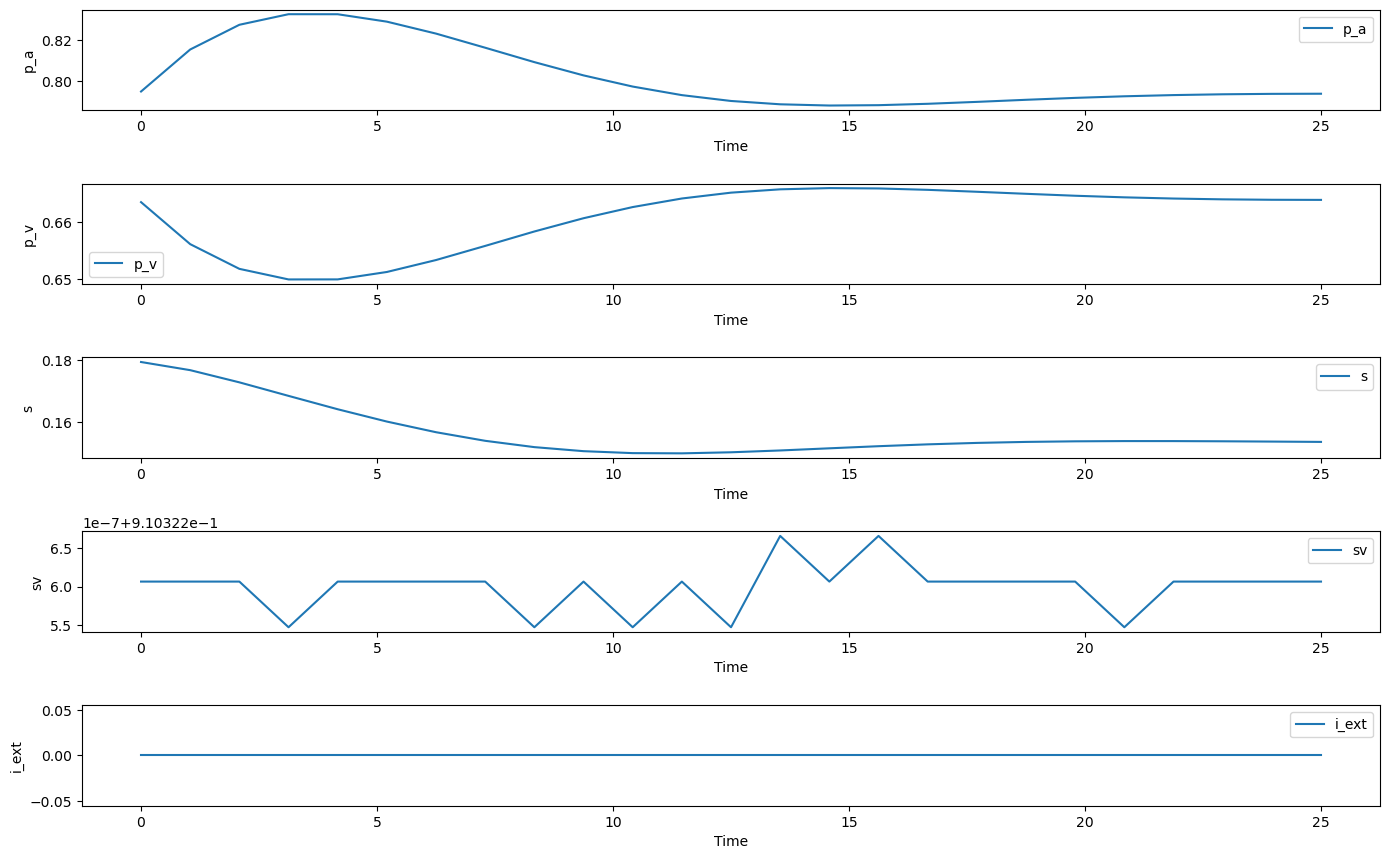

In [621]:

full_traj
ts = torch.linspace(0, t_span, t_span)  # Time vector

def plot_sde_results_with_i_ext(ts, ys):
    plt.figure(figsize=(14, 10))
    num_variables = ys.shape[2]
    labels = ['p_a', 'p_v', 's', 'sv', 'i_ext']

    for i in range(num_variables):
        plt.subplot(num_variables + 1, 1, i + 1)
        plt.plot(ts, ys[:, 7, i], label=f'{labels[i]}')
        plt.xlabel('Time')
        plt.ylabel(labels[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_sde_results_with_i_ext(ts, full_traj)



In [546]:
sde.params

{'r_tpr_mod': 0.0,
 'f_hr_max': 3.0,
 'f_hr_min': 0.6666666666666666,
 'r_tpr_max': 2.134,
 'r_tpr_min': 0.5335,
 'sv_mod': 0.001,
 'ca': 4.0,
 'cv': 111.0,
 'k_width': 0.1838,
 'p_aset': 70,
 'tau': 20,
 'p_0lv': 2.03,
 'r_valve': 0.0025,
 'k_elv': 0.066,
 'v_ed0': 7.14,
 'T_sys': 0.26666666666666666,
 'cprsw_max': 103.8,
 'cprsw_min': 25.9,
 't_treatment': 15,
 'treatment': False,
 'init_pressure': tensor([0.7802, 0.8039, 0.8170, 0.8468]),
 'init_sv': tensor([0.9000, 0.9397, 0.9027, 0.9801])}

In [26]:
gamma=torch.tensor(1)
torch.sigmoid(gamma*0.9) 

tensor(0.7109)

In [510]:
y1.shape

torch.Size([10, 10, 5])

In [536]:


def fluids_input(t):
    return 5*np.exp(-((t-5)/5)**2)

def v_fun(x):
    return 0.02*(np.cos(5*x-0.2) * (5-x)**2)**2

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def dx_dt(state, t, params):
    # Parameters:
    f_hr_max = params["f_hr_max"]
    f_hr_min = params["f_hr_min"]
    r_tpr_max = params["r_tpr_max"]
    r_tpr_min = params["r_tpr_min"]
    ca = params["ca"]
    cv = params["cv"]
    k_width = params["k_width"]
    p_aset = params["p_aset"]
    tau = params["tau"]
    t_treatment = params["t_treatment"]

    # Unknown parameters:
    
    if (params["treatment"]) and (t>=t_treatment):
        initp_transform  = 0.5+(params["init_pressure"]-0.75)/0.1
        A_ = v_fun(initp_transform)
        i_ext = A_ * fluids_input(t-t_treatment)
    else:
        i_ext = 0
    
    
    r_tpr_mod = params["r_tpr_mod"]
    sv_mod = params["sv_mod"]

    ##print('pa, pv, s, sv',state[0], state[1], state[2], state[3])

    # State variables
    p_a = 100. * state[0]
    p_v = 10. * state[1]
    s = state[2]
    sv = 100. * state[3]
    ##print('pa, pv, s, sv',p_a, p_v, s, sv)

    # Building f_hr and r_tpr:
    f_hr = s * (f_hr_max - f_hr_min) + f_hr_min
    r_tpr = s * (r_tpr_max - r_tpr_min) + r_tpr_min - r_tpr_mod

    # Building dp_a/dt and dp_v/dt:
    dva_dt = -1. * (p_a - p_v) / r_tpr + sv * f_hr
    dvv_dt = -1. * dva_dt + i_ext
    dpa_dt = dva_dt / (ca * 100.)
    dpv_dt = dvv_dt / (cv * 10.)

    # Building dS/dt:
    ds_dt = (1. / tau) * (1. - 1. / (1 + np.exp(-1 * k_width * (p_a - p_aset))) - s)

    dsv_dt = i_ext * sv_mod

    # State derivative
    return np.array([dpa_dt, dpv_dt, ds_dt, dsv_dt])

def init_random_state():
    max_ves = 64.0 - 10.0
    min_ves = 36.0 + 10.0

    max_ved = 167.0 - 10.0
    min_ved = 121.0 + 10.0

    max_sv = 1.0
    min_sv = 0.9

    max_pa = 85.0
    min_pa = 75.0

    max_pv = 7.0
    min_pv = 3.0

    max_s = 0.25
    min_s = 0.15

    init_ves = (np.random.rand() * (max_ves - min_ves) + min_ves) / 100.0
    # init_ves = 50.0 / 100.0

    init_ved = (np.random.rand() * (max_ved - min_ved) + min_ved) / 100.0
    # init_ved = 144.0 / 100.0

    init_sv = (np.random.rand() * (max_sv - min_sv) + min_sv)
    init_pa = (np.random.rand() * (max_pa - min_pa) + min_pa) / 100.0
    init_pv = (np.random.rand() * (max_pv - min_pv) + min_pv) / 10.0
    init_s = (np.random.rand() * (max_s - min_s) + min_s)

    init_state = np.array([init_pa, init_pv, init_s, init_sv])
    ##print('init_state', init_state)
    return init_state


def create_cv_data(N,gamma,noise_std, t_span, t_treatment, seed, output_dims, input_dims = [0,1], normalize = True):

    np.random.seed(seed)

    X = []
    Y_0 = []
    Y_1 = []
    init_state_list = []
    
    params = {"r_tpr_mod": 0.,
            "f_hr_max": 3.0,
            "f_hr_min": 2.0 / 3.0,
            "r_tpr_max": 2.134,
            "r_tpr_min": 0.5335,
            "sv_mod": 0.001,
            "ca": 4.0,
            "cv": 111.0,

            # dS/dt parameters
            "k_width": 0.1838,
            "p_aset": 70,
            "tau": 20,
            "p_0lv": 2.03,
            "r_valve": 0.0025,
            "k_elv": 0.066,
            "v_ed0": 7.14,
            "T_sys": 4. / 15.,
            "cprsw_max": 103.8,
            "cprsw_min": 25.9,
            "t_treatment" : t_treatment
            }
    
    params_treatment = params.copy()
    params_treatment["treatment"]=True
    params_notreatment = params.copy()
    params_notreatment["treatment"]=False
    
    t = np.arange(t_span).astype(float)
    
    for i in range(N):
        #create the treated trajectory (with treatment starting at t_treatment = 15 seconds )
        init_state = init_random_state()
        params_treatment["init_pressure"] = init_state[0]
        params_treatment["cv"] = np.random.rand() * 100 + 10
        y1 = odeint(dx_dt,init_state,t,args=tuple([params_treatment]))
        
        #create the untreated trajectory (with same baseline until 15 seconds)
        params_notreatment["init_pressure"] = init_state[0]
        y0 = odeint(dx_dt,init_state,t,args=tuple([params_notreatment]))
        
        #print('y1', y1.shape)
        #print('y0', y0.shape)
        
        X.append(torch.Tensor(init_state))
        Y_0.append(torch.Tensor(y0))
        Y_1.append(torch.Tensor(y1))
        init_state_list.append(torch.Tensor(init_state))
    

    #stack all the initial states 
    init_state = torch.stack(init_state_list)
    #identify the probability of treatment based on the initial states (this is the confounder!)
    # note however, that the probability of tx is affected by the 'initial' state, rather than in the states just before the tx as would be in real life (or at least a combination)
    # gamma determines the extent of the confounding 
    p = torch.sigmoid(gamma*((init_state[:,0]-0.75)/0.1-0.5))
    T = torch.zeros(N)
    #T determines which trajectories as selected as treated (this is confounded by p and gamma)
    T[torch.rand(N)<p] = 1

    Y_0 = torch.stack(Y_0)
    Y_1 = torch.stack(Y_1)
    Y_0 += noise_std * torch.randn(Y_0.shape)
    Y_1 += noise_std * torch.randn(Y_1.shape)
    X = torch.stack(X)
    X += noise_std * torch.randn(X.shape)

    expert_ODE_size = X.shape[1]

    #print('Y_0, Y1, T', Y_0.shape,Y_1.shape, T[:,None,None].shape )
    # the 'factual' trajectories are the UNtreated outcome (Y0) for the not Treated (1-T) and the Treated outcome (Y1) for the factually Treated (T)
    Y_fact = Y_0 * (1-T)[:,None,None] + Y_1 * T[:,None,None]
    # the 'COUNTERfactual' trajectories are the UNtreated outcome (Y0) for the Treated (T) and the Treated outcome (Y1) for the factually UNtreated (1-T)
    # we would never actually have access to the counterfactual other than in this situation where we are simulating it 
    Y_cf = Y_0 * (T)[:,None,None] + Y_1 * (1-T)[:,None,None]

    
    Y_fact_np = Y_fact.detach().cpu().numpy()
    states_mean = Y_fact_np.mean(axis=(0, 1))
    states_min = Y_fact_np.min(axis=(0, 1))
    states_max = Y_fact_np.max(axis=(0, 1))
    ##print('states_mean', states_mean, 'states_min', states_min, 'states_max', states_max)

    if normalize:
        mu = Y_fact.mean([0,1])
        std = Y_fact.std([0,1])

        Y_fact = (Y_fact - mu)/std
        Y_cf = (Y_cf - mu)/std
        
        mu_X = X.mean([0,1])
        std_X = X.std([0,1])
        X = (X-mu_X)/std_X
    
    # Now split these factual and counterfactual trajectories by the 'before' and 'after treatment' so we have a baseline 
    pre_treat_mask = (t<=t_treatment)
    post_treat_mask = (t>t_treatment)
    
    # We define X as the Factual trajectory BEFORE treatment, and X_ as the COUNTERfactual traj BEFORE treatment 
    X_static = X
    X = Y_fact[:,pre_treat_mask][:,:,input_dims]
    X_ = Y_cf[:,pre_treat_mask][:,:,input_dims]

    # We redfine Y_fact as the Factual trajectory AFTER treatment, and Y_cf as the COUNTERfactual traj AFTER treatment 
    # We are selecting the DIASTOLIC BP (output dim = 1) as the one to maintain.. this is because the fluid is only really affecting this within the time values
    Y_fact = Y_fact[:,post_treat_mask][:,:,output_dims] 
    Y_cf = Y_cf[:,post_treat_mask][:,:,output_dims]

    # we split the time vector also as before and after treatment 
    t_x = t[pre_treat_mask]
    t_y = t[post_treat_mask]
    # and get it to match the dimensions, so it's not a vector t, but a matrix of dimensions N by before_tx and N by after_tx
    t_X = torch.Tensor(np.tile(t_x[None,:],(X.shape[0],1)))
    t_Y = torch.Tensor(np.tile(t_y[None,:],(Y_fact.shape[0],1))) - t_x[-1]

    full_traj = Y_fact


    return X, X_static, T, Y_fact, Y_cf, p, init_state, t_X, t_Y, expert_ODE_size, full_traj



X, X_static, T, Y_fact, Y_cf, p, init, t_X, t_Y, expert_ODE_size, full_traj = create_cv_data(N = 2, gamma = 0, noise_std = 0, t_span = 25, t_treatment = 15, seed = 1, output_dims = [1])


y1 (25, 4)
y0 (25, 4)
y1 (25, 4)
y0 (25, 4)
Y_0, Y1, T torch.Size([2, 25, 4]) torch.Size([2, 25, 4]) torch.Size([2, 1, 1])
